In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import segmentation_models_pytorch as smp
import SimpleITK as sitk
import matplotlib.pyplot as plt
import cv2
import seaborn as sns


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEG_CHECKPOINT = './checkpoints/best_model_v2.pth'

BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
DATA_DIR = os.path.join(BASE_DIR, '3_only_box')
IMAGE_DIR = os.path.join(DATA_DIR, 'train_images')
CONV_DIR = os.path.join(DATA_DIR, 'converted_images') # 결과 저장 폴더
MASK_SAVE_ROOT = os.path.join(BASE_DIR, 'seg_results_masks')   # 마스크 저장 경로
SEG_CHECKPOINT = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\checkpoints\best_model_v2.pth'
GROUPS = ['1_mask_and_box', '3_only_box']
GT_MASK_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\1_mask_and_box\segmentations'

# 학습 시 설정 (반드시 확인!)
WL, WW = 500, 2000 

## dicom -> nifti (195명)

In [45]:
def convert_safe_version(image_dir, conv_dir):
    if not os.path.exists(conv_dir):
        os.makedirs(conv_dir)

    uids = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
    
    for uid in tqdm(uids, desc="Safe Converting"):
        dicom_dir = os.path.join(image_dir, uid)
        # 확장자를 .nii.gz로 명시하여 압축 저장 유도 (용량 절약 및 에러 방지)
        output_path = os.path.join(conv_dir, f"{uid}.nii.gz")
        
        if os.path.exists(output_path): continue

        try:
            reader = sitk.ImageSeriesReader()
            # [Step 1] Z-position 기반 자동 정렬
            dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)
            
            if not dicom_names: continue
                
            reader.SetFileNames(dicom_names)
            image = reader.Execute()
            
            # [Step 2] LAS 방향 표준화
            image = sitk.DICOMOrient(image, 'LAS')
            
            # [Step 3] 저장 (가장 에러가 많이 나는 지점)
            # 경로를 절대 경로로 확실히 변환하여 전달
            abs_output_path = os.path.abspath(output_path)
            sitk.WriteImage(image, abs_output_path)
            
        except Exception as e:
            print(f"\n❌ {uid}에서 문제 발생: {e}")
            # 에러 발생 시 해당 파일이 불완전하게 생성되었을 수 있으니 삭제
            if os.path.exists(output_path):
                os.remove(output_path)

convert_safe_version(IMAGE_DIR, CONV_DIR)

Safe Converting: 100%|██████████| 195/195 [18:56<00:00,  5.83s/it]


## det 전처리

In [103]:
import os
import numpy as np
import pydicom
import SimpleITK as sitk
from tqdm import tqdm

# --- [1. 경로 및 하이퍼파라미터 설정] ---
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
MASK_DIR = os.path.join(BASE_DIR, 'seg_pseudo_masks') # 교정된 0.91 마스크 폴더
DET_SAVE_ROOT = os.path.join(BASE_DIR, 'detection_preprocessed') 

GROUPS = ['1_mask_and_box', '3_only_box']
WL, WW = 500, 2000
BUFFER = 5 # 뼈 시작/끝 지점 앞뒤 여유분

os.makedirs(DET_SAVE_ROOT, exist_ok=True)

# --- [2. 핵심 함수: SEG ver 3 로직 그대로] ---
def apply_windowing(img, wl, ww):
    img_min, img_max = wl - ww // 2, wl + ww // 2
    img = np.clip(img, img_min, img_max)
    return ((img - img_min) / ww).astype(np.float32)

# --- [3. 메인 전처리 루프] ---
for group in GROUPS:
    image_root = os.path.join(BASE_DIR, group, 'train_images')
    if not os.path.exists(image_root): continue
    
    uids = [d for d in os.listdir(image_root) if os.path.isdir(os.path.join(image_root, d))]
    print(f"\n🚀 [{group}] 그룹 DET 데이터 생성 시작 (Buffer: {BUFFER})")

    for uid in tqdm(uids):
        patient_save_dir = os.path.join(DET_SAVE_ROOT, uid)
        
        try:
            # A. DICOM 메타데이터 추출 및 물리적 정렬 (SEG ver 3 로직)
            dicom_dir = os.path.join(image_root, uid)
            dcm_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
            dcm_data_list = []

            for f in dcm_files:
                ds = pydicom.dcmread(os.path.join(dicom_dir, f), stop_before_pixels=True)
                dcm_data_list.append({
                    'path': os.path.join(dicom_dir, f),
                    'z_pos': float(ds.ImagePositionPatient[2]),
                    'slope': float(ds.RescaleSlope) if 'RescaleSlope' in ds else 1.0,
                    'intercept': float(ds.RescaleIntercept) if 'RescaleIntercept' in ds else 0.0
                })

            # [핵심] 머리(Superior) -> 발(Inferior) 순서 정렬
            dcm_data_list.sort(key=lambda x: x['z_pos'], reverse=True)
            total_z = len(dcm_data_list)

            # B. 교정된 NIfTI 마스크 로드 (Z, 512, 512)
            mask_path = os.path.join(MASK_DIR, f"{uid}_mask.nii.gz")
            if not os.path.exists(mask_path): continue
            
            mask_vol = sitk.GetArrayFromImage(sitk.ReadImage(mask_path)).astype(np.uint8)
            
            # C. 해부학적 필터링 범위 계산 (뼈 1~7번 기준)
            z_indices = np.where(np.any(mask_vol > 0, axis=(1, 2)))[0]
            if len(z_indices) == 0: continue
            
            start_z = max(0, z_indices.min() - BUFFER)
            end_z = min(total_z - 1, z_indices.max() + BUFFER)

            if not os.path.exists(patient_save_dir):
                os.makedirs(patient_save_dir)

            # D. 4채널 패킹 저장 루프 (No Resampling)
            for z in range(start_z, end_z + 1):
                # 2.5D용 인덱스 설정 (n-1, n, n+1)
                indices = [max(0, z-1), z, min(total_z-1, z+1)]
                
                # 채널 1~3: 이미지 데이터 (Rescale + Windowing)
                img_3ch = []
                for idx in indices:
                    item = dcm_data_list[idx]
                    ds = pydicom.dcmread(item['path'])
                    img = ds.pixel_array.astype(np.float32) * item['slope'] + item['intercept']
                    img_3ch.append(apply_windowing(img, WL, WW))
                
                # 채널 4: 마스크 데이터
                mask_slice = mask_vol[z].astype(np.float32) / 7.0 # 0~1 정규화
                
                # 최종 패킹 (4, 512, 512)
                combined = np.stack(img_3ch + [mask_slice], axis=0)
                
                # 저장명: 슬라이스 인덱스 유지 (예: 0145.npy)
                np.savez_compressed(os.path.join(patient_save_dir, f"{z:04d}.npz"), data=combined)

        except Exception as e:
            print(f"❌ {uid} 처리 중 오류: {e}")

print(f"\n✨ 모든 환자의 DET 데이터셋 생성이 완료되었습니다!")


🚀 [1_mask_and_box] 그룹 DET 데이터 생성 시작 (Buffer: 5)


100%|██████████| 40/40 [12:40<00:00, 19.02s/it]



🚀 [3_only_box] 그룹 DET 데이터 생성 시작 (Buffer: 5)


100%|██████████| 195/195 [1:07:04<00:00, 20.64s/it]


✨ 모든 환자의 DET 데이터셋 생성이 완료되었습니다!


## 전처리 결과 시각화

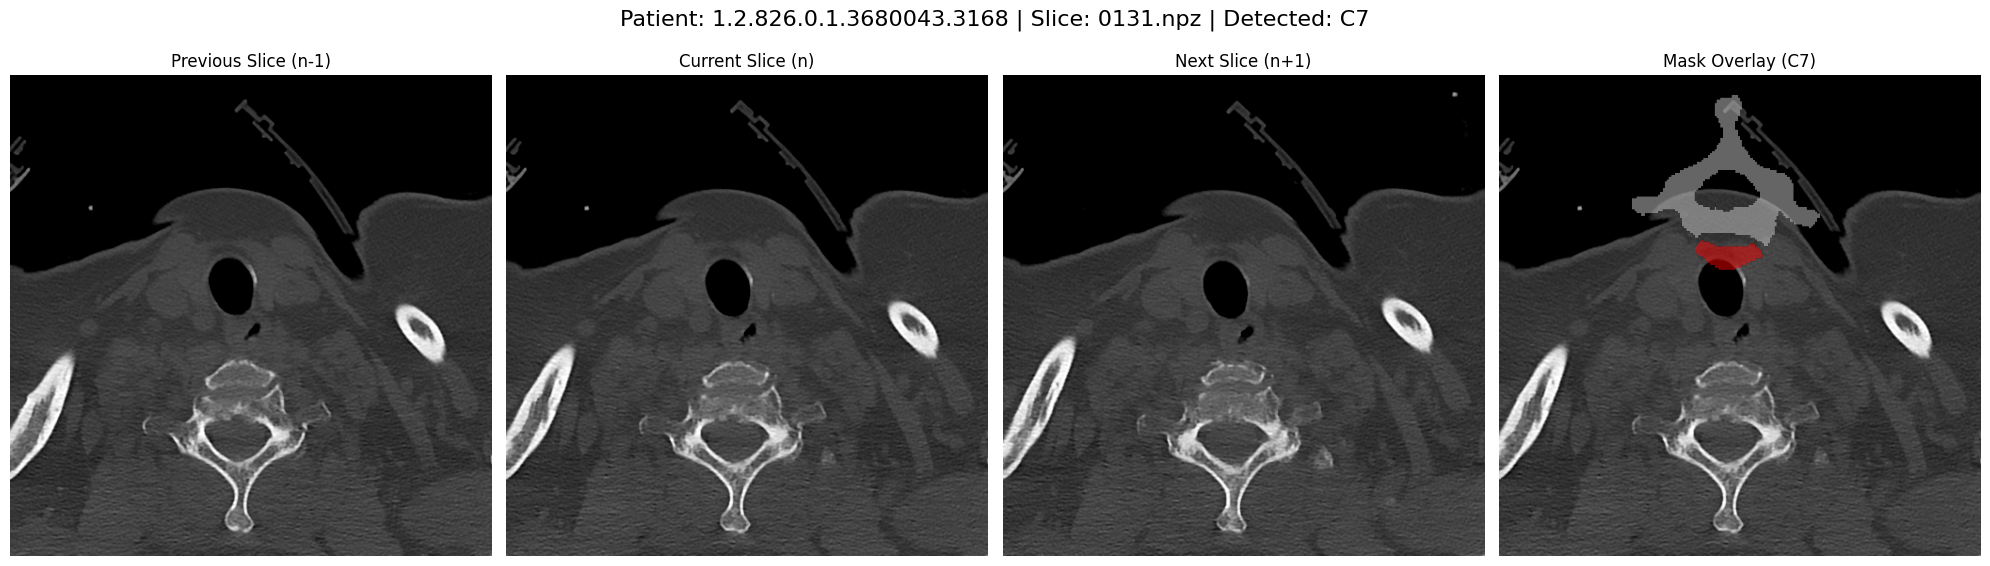

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

# --- [1. 설정] ---
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
DET_DATA_DIR = os.path.join(BASE_DIR, 'detection_preprocessed')

def visualize_det_sample(patient_uid=None, slice_idx=None):
    # 환자 및 슬라이스 무작위 선택 (지정하지 않았을 경우)
    if patient_uid is None:
        patient_folders = [d for d in os.listdir(DET_DATA_DIR) if os.path.isdir(os.path.join(DET_DATA_DIR, d))]
        patient_uid = np.random.choice(patient_folders)
    
    slice_path = os.path.join(DET_DATA_DIR, patient_uid)
    slice_files = glob.glob(os.path.join(slice_path, "*.npz"))
    
    if not slice_files:
        print(f"❌ {patient_uid} 폴더에 데이터가 없습니다.")
        return

    target_file = np.random.choice(slice_files) if slice_idx is None else os.path.join(slice_path, f"{slice_idx:04d}.npz")

    # --- [2. 데이터 로드] ---
    with np.load(target_file) as loaded:
        data = loaded['data'] # (4, 512, 512)
    
    img_prev = data[0] # n-1 슬라이스
    img_curr = data[1] # n 슬라이스 (메인)
    img_next = data[2] # n+1 슬라이스
    mask_norm = data[3] # 0~1로 정규화된 마스크
    
    # 마스크 복원 (0~7)
    mask = np.round(mask_norm * 7).astype(np.uint8)
    v_level = np.max(mask)
    v_name = {0:'None', 1:'C1', 2:'C2', 3:'C3', 4:'C4', 5:'C5', 6:'C6', 7:'C7'}.get(v_level, 'Unknown')

    # --- [3. 시각화] ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    plt.suptitle(f"Patient: {patient_uid} | Slice: {os.path.basename(target_file)} | Detected: {v_name}", fontsize=16)

    # 1채널: 이전 슬라이스
    axes[0].imshow(img_prev, cmap='gray')
    axes[0].set_title("Previous Slice (n-1)")
    axes[0].axis('off')

    # 2채널: 현재 슬라이스 (메인)
    axes[1].imshow(img_curr, cmap='gray')
    axes[1].set_title("Current Slice (n)")
    axes[1].axis('off')

    # 3채널: 다음 슬라이스
    axes[2].imshow(img_next, cmap='gray')
    axes[2].set_title("Next Slice (n+1)")
    axes[2].axis('off')

    # 4채널: 마스크 오버레이 (현재 슬라이스 기준)
    axes[3].imshow(img_curr, cmap='gray')
    if np.any(mask > 0):
        masked = np.ma.masked_where(mask == 0, mask)
        axes[3].imshow(masked, cmap='nipy_spectral', alpha=0.5, vmin=0, vmax=7)
    axes[3].set_title(f"Mask Overlay ({v_name})")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

# 실행: 무작위 샘플 확인
visualize_det_sample()

## det 전처리 (2트)

In [2]:
import os
import numpy as np
import pydicom
import SimpleITK as sitk
from tqdm import tqdm

# --- [1. 경로 및 하이퍼파라미터 설정] ---
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
MASK_DIR = os.path.join(BASE_DIR, 'seg_pseudo_masks') 
DET_SAVE_ROOT = os.path.join(BASE_DIR, 'detection_preprocessed') 

GROUPS = ['1_mask_and_box', '3_only_box']
WL, WW = 500, 2000
BUFFER = 5 

os.makedirs(DET_SAVE_ROOT, exist_ok=True)

# --- [2. 핵심 함수] ---
def apply_windowing(img, wl, ww):
    img_min, img_max = wl - ww // 2, wl + ww // 2
    img = np.clip(img, img_min, img_max)
    return ((img - img_min) / ww).astype(np.float32)

# --- [3. 메인 전처리 루프] ---
for group in GROUPS:
    image_root = os.path.join(BASE_DIR, group, 'train_images')
    if not os.path.exists(image_root): continue
    
    uids = [d for d in os.listdir(image_root) if os.path.isdir(os.path.join(image_root, d))]
    print(f"\n🚀 [{group}] 그룹 DET 데이터 생성 시작 (Buffer: {BUFFER})")

    for uid in tqdm(uids):
        patient_save_dir = os.path.join(DET_SAVE_ROOT, uid)
        
        try:
            # A. DICOM 정렬 (머리 -> 발)
            dicom_dir = os.path.join(image_root, uid)
            dcm_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
            dcm_data_list = []

            for f in dcm_files:
                ds = pydicom.dcmread(os.path.join(dicom_dir, f), stop_before_pixels=True)
                dcm_data_list.append({
                    'path': os.path.join(dicom_dir, f),
                    'z_pos': float(ds.ImagePositionPatient[2]),
                    'slope': float(ds.RescaleSlope) if 'RescaleSlope' in ds else 1.0,
                    'intercept': float(ds.RescaleIntercept) if 'RescaleIntercept' in ds else 0.0
                })

            # 머리(큰 값) -> 발(작은 값) 순서로 정렬
            dcm_data_list.sort(key=lambda x: x['z_pos'], reverse=True)
            total_z = len(dcm_data_list)

            # B. 마스크 로드 및 [Z-축 반전 교정]
            mask_path = os.path.join(MASK_DIR, f"{uid}_mask.nii.gz")
            if not os.path.exists(mask_path): continue
            
            # SimpleITK 배열을 읽어온 후 즉시 Z축(axis 0)을 뒤집습니다.
            mask_vol = sitk.GetArrayFromImage(sitk.ReadImage(mask_path)).astype(np.uint8)
            mask_vol = np.flip(mask_vol, axis=0) # <--- 이 부분이 핵심 수정 사항입니다!

            # C. 해부학적 필터링 범위 계산
            z_indices = np.where(np.any(mask_vol > 0, axis=(1, 2)))[0]
            if len(z_indices) == 0: continue
            
            start_z = max(0, z_indices.min() - BUFFER)
            end_z = min(total_z - 1, z_indices.max() + BUFFER)

            if not os.path.exists(patient_save_dir):
                os.makedirs(patient_save_dir)

            # D. 4채널 패킹 저장 루프
            for z in range(start_z, end_z + 1):
                indices = [max(0, z-1), z, min(total_z-1, z+1)]
                
                img_3ch = []
                for idx in indices:
                    item = dcm_data_list[idx]
                    ds = pydicom.dcmread(item['path'])
                    img = ds.pixel_array.astype(np.float32) * item['slope'] + item['intercept']
                    img_3ch.append(apply_windowing(img, WL, WW))
                
                mask_slice = mask_vol[z].astype(np.float32) / 7.0 
                
                combined = np.stack(img_3ch + [mask_slice], axis=0)
                
                # 압축 저장 (Key 이름을 'data'로 설정)
                np.savez_compressed(os.path.join(patient_save_dir, f"{z:04d}.npz"), data=combined)

        except Exception as e:
            print(f"❌ {uid} 처리 중 오류: {e}")

print(f"\n✨ 모든 환자의 DET 데이터셋 생성이 완료되었습니다!")


🚀 [1_mask_and_box] 그룹 DET 데이터 생성 시작 (Buffer: 5)


100%|██████████| 40/40 [13:02<00:00, 19.56s/it]



🚀 [3_only_box] 그룹 DET 데이터 생성 시작 (Buffer: 5)


100%|██████████| 195/195 [1:06:06<00:00, 20.34s/it]


✨ 모든 환자의 DET 데이터셋 생성이 완료되었습니다!


## 전처리 결과 시각화 (2트)

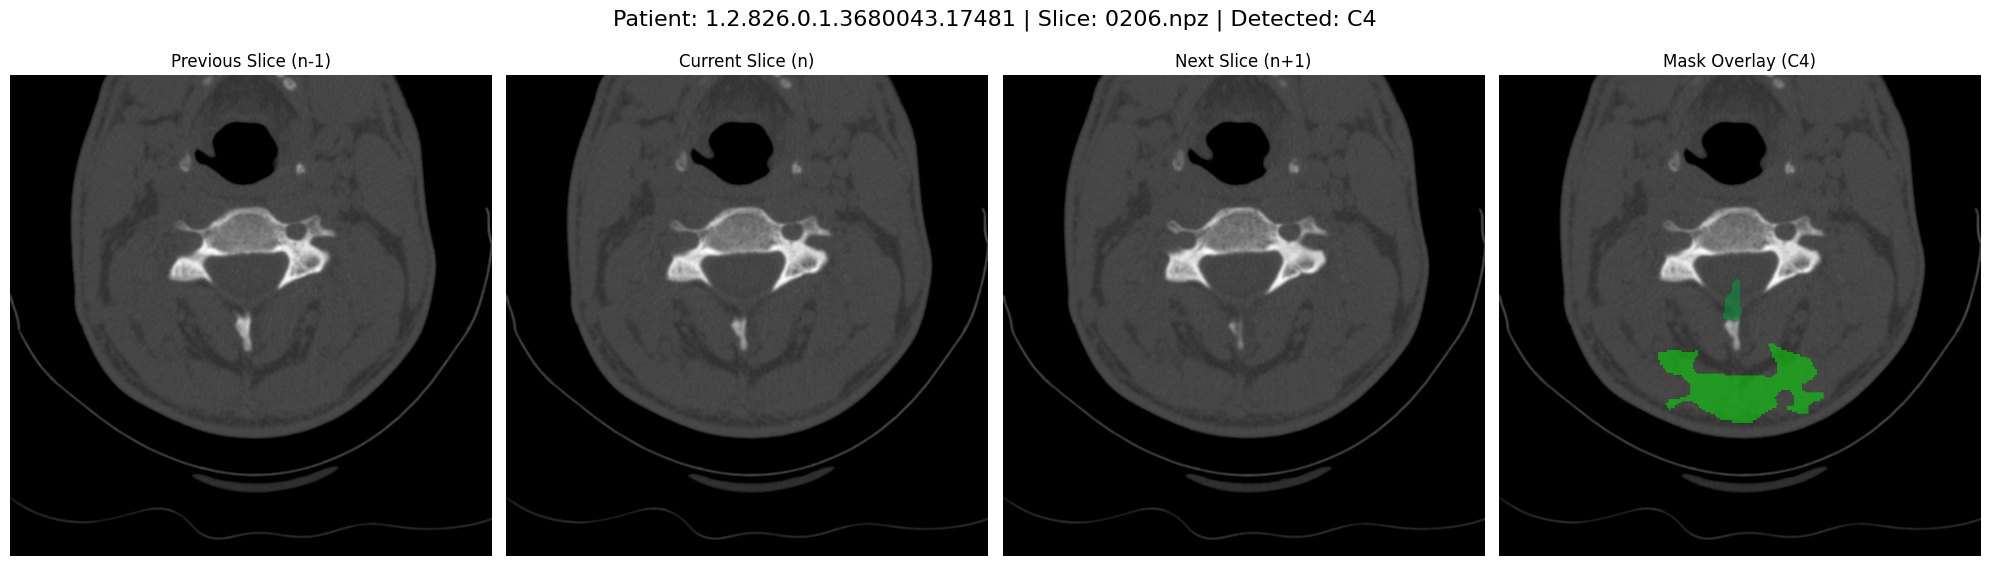

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

# --- [1. 설정] ---
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
DET_DATA_DIR = os.path.join(BASE_DIR, 'detection_preprocessed')

def visualize_det_sample(patient_uid=None, slice_idx=None):
    # 환자 및 슬라이스 무작위 선택 (지정하지 않았을 경우)
    if patient_uid is None:
        patient_folders = [d for d in os.listdir(DET_DATA_DIR) if os.path.isdir(os.path.join(DET_DATA_DIR, d))]
        patient_uid = np.random.choice(patient_folders)
    
    slice_path = os.path.join(DET_DATA_DIR, patient_uid)
    slice_files = glob.glob(os.path.join(slice_path, "*.npz"))
    
    if not slice_files:
        print(f"❌ {patient_uid} 폴더에 데이터가 없습니다.")
        return

    target_file = np.random.choice(slice_files) if slice_idx is None else os.path.join(slice_path, f"{slice_idx:04d}.npz")

    # --- [2. 데이터 로드] ---
    with np.load(target_file) as loaded:
        data = loaded['data'] # (4, 512, 512)
    
    img_prev = data[0] # n-1 슬라이스
    img_curr = data[1] # n 슬라이스 (메인)
    img_next = data[2] # n+1 슬라이스
    mask_norm = data[3] # 0~1로 정규화된 마스크
    
    # 마스크 복원 (0~7)
    mask = np.round(mask_norm * 7).astype(np.uint8)
    v_level = np.max(mask)
    v_name = {0:'None', 1:'C1', 2:'C2', 3:'C3', 4:'C4', 5:'C5', 6:'C6', 7:'C7'}.get(v_level, 'Unknown')

    # --- [3. 시각화] ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    plt.suptitle(f"Patient: {patient_uid} | Slice: {os.path.basename(target_file)} | Detected: {v_name}", fontsize=16)

    # 1채널: 이전 슬라이스
    axes[0].imshow(img_prev, cmap='gray')
    axes[0].set_title("Previous Slice (n-1)")
    axes[0].axis('off')

    # 2채널: 현재 슬라이스 (메인)
    axes[1].imshow(img_curr, cmap='gray')
    axes[1].set_title("Current Slice (n)")
    axes[1].axis('off')

    # 3채널: 다음 슬라이스
    axes[2].imshow(img_next, cmap='gray')
    axes[2].set_title("Next Slice (n+1)")
    axes[2].axis('off')

    # 4채널: 마스크 오버레이 (현재 슬라이스 기준)
    axes[3].imshow(img_curr, cmap='gray')
    if np.any(mask > 0):
        masked = np.ma.masked_where(mask == 0, mask)
        axes[3].imshow(masked, cmap='nipy_spectral', alpha=0.5, vmin=0, vmax=7)
    axes[3].set_title(f"Mask Overlay ({v_name})")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

# 실행: 무작위 샘플 확인
visualize_det_sample()

c:\Users\smc\anaconda3\envs\torch_cu13\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\smc\anaconda3\envs\torch_cu13\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\smc\anaconda3\envs\torch_cu13\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\smc\anaconda3\envs\torch_cu13\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\smc\anaconda3\envs\torch_cu13\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE

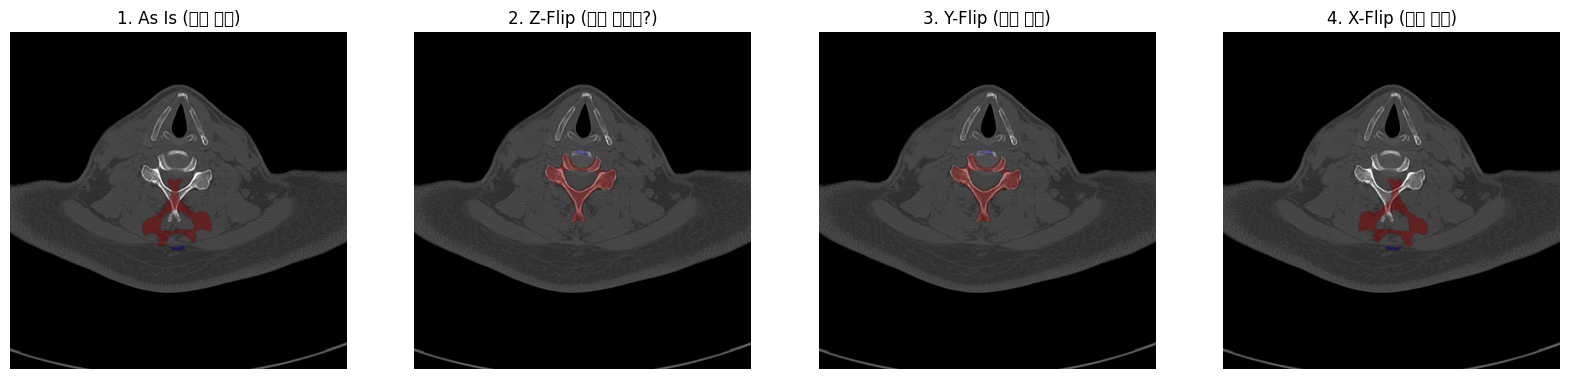

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def diagnostic_flip_check(patient_uid, slice_idx):
    path = os.path.join(DET_DATA_DIR, patient_uid, f"{slice_idx:04d}.npz")
    with np.load(path) as loaded:
        data = loaded['data'] # (4, 512, 512)
    
    img = data[1]    # 현재 슬라이스 이미지
    mask = data[3]   # 저장된 마스크 (문제가 있는 놈)

    # 4가지 경우의 수
    cases = {
        "1. As Is (현재 상태)": mask,
        "2. Z-Flip (이미 뒤집힘?)": np.flip(mask, axis=0), # 사실 이건 낱장이라 의미없음
        "3. Y-Flip (상하 반전)": np.flip(mask, axis=0),   # 배열 내 Y축(상하) 반전
        "4. X-Flip (좌우 반전)": np.flip(mask, axis=1)    # 배열 내 X축(좌우) 반전
    }
    
    # 2D 이미지이므로 사실 axis=0이 상하(Y), axis=1이 좌우(X)입니다.
    # 만약 'Z+Y Flip'이 문제였다면, 여기서는 '상하 반전'이 정답일 확률이 높습니다.

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for i, (title, m) in enumerate(cases.items()):
        axes[i].imshow(img, cmap='gray')
        if np.any(m > 0):
            masked = np.ma.masked_where(m == 0, m)
            axes[i].imshow(masked, cmap='jet', alpha=0.5)
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.show()

# 실행해서 어떤 게 딱 맞는지 번호를 알려주세요!
diagnostic_flip_check("1.2.826.0.1.3680043.13444", 229)

## det 전처리 (3트)

In [ ]:
import os
import numpy as np
import pydicom
import SimpleITK as sitk
from tqdm import tqdm

# --- [1. 경로 및 하이퍼파라미터 설정] ---
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
MASK_DIR = os.path.join(BASE_DIR, 'seg_pseudo_masks') 
DET_SAVE_ROOT = os.path.join(BASE_DIR, 'detection_preprocessed') 

GROUPS = ['1_mask_and_box', '3_only_box']
WL, WW = 500, 2000
BUFFER = 5 

os.makedirs(DET_SAVE_ROOT, exist_ok=True)

# --- [2. 핵심 함수] ---
def apply_windowing(img, wl, ww):
    img_min, img_max = wl - ww // 2, wl + ww // 2
    img = np.clip(img, img_min, img_max)
    return ((img - img_min) / ww).astype(np.float32)

# --- [3. 메인 전처리 루프] ---
for group in GROUPS:
    image_root = os.path.join(BASE_DIR, group, 'train_images')
    if not os.path.exists(image_root): continue
    
    uids = [d for d in os.listdir(image_root) if os.path.isdir(os.path.join(image_root, d))]
    print(f"\n🚀 [{group}] 그룹 DET 데이터 생성 시작 (Z+Y Flip 적용)")

    for uid in tqdm(uids):
        patient_save_dir = os.path.join(DET_SAVE_ROOT, uid)
        
        try:
            # A. DICOM 정렬 (머리 -> 발)
            dicom_dir = os.path.join(image_root, uid)
            dcm_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
            dcm_data_list = []

            for f in dcm_files:
                ds = pydicom.dcmread(os.path.join(dicom_dir, f), stop_before_pixels=True)
                dcm_data_list.append({
                    'path': os.path.join(dicom_dir, f),
                    'z_pos': float(ds.ImagePositionPatient[2]),
                    'slope': float(ds.RescaleSlope) if 'RescaleSlope' in ds else 1.0,
                    'intercept': float(ds.RescaleIntercept) if 'RescaleIntercept' in ds else 0.0
                })

            # 머리(Superior) -> 발(Inferior) 순서 정렬
            dcm_data_list.sort(key=lambda x: x['z_pos'], reverse=True)
            total_z = len(dcm_data_list)

            # B. 마스크 로드 및 [Z축 + Y축 동시 반전]
            mask_path = os.path.join(MASK_DIR, f"{uid}_mask.nii.gz")
            if not os.path.exists(mask_path): continue
            
            mask_vol = sitk.GetArrayFromImage(sitk.ReadImage(mask_path)).astype(np.uint8)
            
            # [🔥 수정 포인트] 
            # axis=0: 슬라이스 순서(Z) 뒤집기
            # axis=1: 이미지 상하(Y) 뒤집기
            mask_vol = np.flip(mask_vol, axis=(0, 1)) 

            # C. 해부학적 필터링 범위 계산
            z_indices = np.where(np.any(mask_vol > 0, axis=(1, 2)))[0]
            if len(z_indices) == 0: continue
            
            start_z = max(0, z_indices.min() - BUFFER)
            end_z = min(total_z - 1, z_indices.max() + BUFFER)

            if not os.path.exists(patient_save_dir):
                os.makedirs(patient_save_dir)

            # D. 4채널 패킹 저장 루프 내부
            for z in range(start_z, end_z + 1):
                indices = [max(0, z-1), z, min(total_z-1, z+1)]
    
                img_3ch = []
                for idx in indices:
                    item = dcm_data_list[idx]
                    ds = pydicom.dcmread(item['path'])
                    img = ds.pixel_array.astype(np.float32) * item['slope'] + item['intercept']
    
            combined = np.stack(img_3ch + [mask_slice], axis=0)
    
            # 압축 저장
            np.savez_compressed(os.path.join(patient_save_dir, f"{z:04d}.npz"), data=combined)

        except Exception as e:
            print(f"❌ {uid} 처리 중 오류: {e}")

print(f"\n✨ 모든 환자의 DET 데이터셋 생성이 완료되었습니다!")


🚀 [1_mask_and_box] 그룹 DET 데이터 생성 시작 (Z+Y Flip 적용)


100%|██████████| 40/40 [13:12<00:00, 19.81s/it]



🚀 [3_only_box] 그룹 DET 데이터 생성 시작 (Z+Y Flip 적용)


100%|██████████| 195/195 [1:06:12<00:00, 20.37s/it]


✨ 모든 환자의 DET 데이터셋 생성이 완료되었습니다!


## 전처리 결과 시각화 (3트)

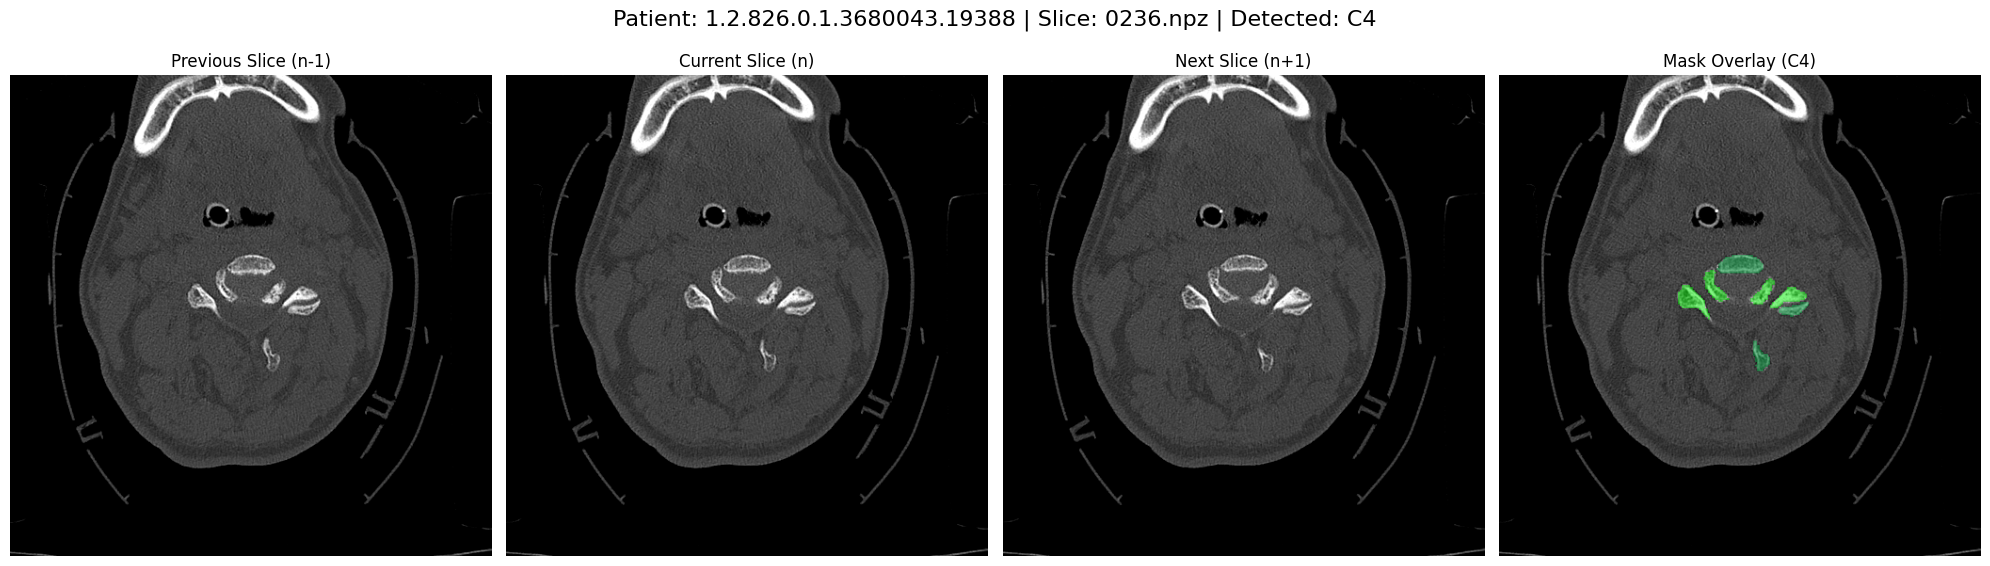

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

# --- [1. 설정] ---
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
DET_DATA_DIR = os.path.join(BASE_DIR, 'detection_preprocessed')

def visualize_det_sample(patient_uid=None, slice_idx=None):
    # 환자 및 슬라이스 무작위 선택 (지정하지 않았을 경우)
    if patient_uid is None:
        patient_folders = [d for d in os.listdir(DET_DATA_DIR) if os.path.isdir(os.path.join(DET_DATA_DIR, d))]
        patient_uid = np.random.choice(patient_folders)
    
    slice_path = os.path.join(DET_DATA_DIR, patient_uid)
    slice_files = glob.glob(os.path.join(slice_path, "*.npz"))
    
    if not slice_files:
        print(f"❌ {patient_uid} 폴더에 데이터가 없습니다.")
        return

    target_file = np.random.choice(slice_files) if slice_idx is None else os.path.join(slice_path, f"{slice_idx:04d}.npz")

    # --- [2. 데이터 로드] ---
    with np.load(target_file) as loaded:
        data = loaded['data'] # (4, 512, 512)
    
    img_prev = data[0] # n-1 슬라이스
    img_curr = data[1] # n 슬라이스 (메인)
    img_next = data[2] # n+1 슬라이스
    mask_norm = data[3] # 0~1로 정규화된 마스크
    
    # 마스크 복원 (0~7)
    mask = np.round(mask_norm * 7).astype(np.uint8)
    v_level = np.max(mask)
    v_name = {0:'None', 1:'C1', 2:'C2', 3:'C3', 4:'C4', 5:'C5', 6:'C6', 7:'C7'}.get(v_level, 'Unknown')

    # --- [3. 시각화] ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    plt.suptitle(f"Patient: {patient_uid} | Slice: {os.path.basename(target_file)} | Detected: {v_name}", fontsize=16)

    # 1채널: 이전 슬라이스
    axes[0].imshow(img_prev, cmap='gray')
    axes[0].set_title("Previous Slice (n-1)")
    axes[0].axis('off')

    # 2채널: 현재 슬라이스 (메인)
    axes[1].imshow(img_curr, cmap='gray')
    axes[1].set_title("Current Slice (n)")
    axes[1].axis('off')

    # 3채널: 다음 슬라이스
    axes[2].imshow(img_next, cmap='gray')
    axes[2].set_title("Next Slice (n+1)")
    axes[2].axis('off')

    # 4채널: 마스크 오버레이 (현재 슬라이스 기준)
    axes[3].imshow(img_curr, cmap='gray')
    if np.any(mask > 0):
        masked = np.ma.masked_where(mask == 0, mask)
        axes[3].imshow(masked, cmap='nipy_spectral', alpha=0.5, vmin=0, vmax=7)
    axes[3].set_title(f"Mask Overlay ({v_name})")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

# 실행: 무작위 샘플 확인
visualize_det_sample()

## det 전처리 (4트)

In [1]:
import os
import numpy as np
import pydicom
import SimpleITK as sitk
import cv2  # [추가] 리사이즈용
from tqdm import tqdm

# --- [1. 경로 및 설정] ---
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
MASK_DIR = os.path.join(BASE_DIR, 'seg_pseudo_masks') 
DET_SAVE_ROOT = os.path.join(BASE_DIR, 'detection_preprocessed') 
GROUPS = ['1_mask_and_box', '3_only_box']
WL, WW = 500, 2000
BUFFER = 5 
TARGET_SIZE = 224 # 리사이즈 규격 고정

os.makedirs(DET_SAVE_ROOT, exist_ok=True)

def apply_windowing(img, wl, ww):
    img_min, img_max = wl - ww // 2, wl + ww // 2
    img = np.clip(img, img_min, img_max)
    return ((img - img_min) / ww).astype(np.float32)

# --- [3. 메인 루프] ---
for group in GROUPS:
    image_root = os.path.join(BASE_DIR, group, 'train_images')
    if not os.path.exists(image_root): continue
    
    uids = [d for d in os.listdir(image_root) if os.path.isdir(os.path.join(image_root, d))]
    print(f"\n🚀 [{group}] 그룹 고속 전처리 시작")

    for uid in tqdm(uids):
        patient_save_dir = os.path.join(DET_SAVE_ROOT, uid)
        if not os.path.exists(patient_save_dir): os.makedirs(patient_save_dir)
        
        try:
            # A. DICOM 정보 수집 및 정렬
            dicom_dir = os.path.join(image_root, uid)
            dcm_files = sorted([f for f in os.listdir(dicom_dir) if f.endswith('.dcm')])
            
            # 메타데이터를 먼저 읽어 정렬 (z_pos 기준)
            dcm_meta = []
            for f in dcm_files:
                ds = pydicom.dcmread(os.path.join(dicom_dir, f), stop_before_pixels=True)
                dcm_meta.append({
                    'path': os.path.join(dicom_dir, f),
                    'z_pos': float(ds.ImagePositionPatient[2]),
                    'slope': float(getattr(ds, 'RescaleSlope', 1.0)),
                    'intercept': float(getattr(ds, 'RescaleIntercept', 0.0))
                })
            dcm_meta.sort(key=lambda x: x['z_pos'], reverse=True)
            
            # B. 전체 볼륨 한 번에 로드 (중복 읽기 방지!)
            full_vol = []
            for m in dcm_meta:
                ds = pydicom.dcmread(m['path'])
                px = ds.pixel_array.astype(np.float32) * m['slope'] + m['intercept']
                # 리사이즈 및 윈도잉 미리 적용
                px_res = cv2.resize(px, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_LINEAR)
                full_vol.append(apply_windowing(px_res, WL, WW))
            full_vol = np.stack(full_vol, axis=0) # (Z, 224, 224)

            # C. 마스크 로드 및 전처리
            mask_path = os.path.join(MASK_DIR, f"{uid}_mask.nii.gz")
            if not os.path.exists(mask_path): continue
            
            mask_itk = sitk.ReadImage(mask_path)
            mask_vol = sitk.GetArrayFromImage(mask_itk).astype(np.uint8)
            # [중요] 축 뒤집기 (Z+Y Flip)
            mask_vol = np.flip(mask_vol, axis=(0, 1)) 

            # D. 슬라이싱 및 저장
            z_indices = np.where(np.any(mask_vol > 0, axis=(1, 2)))[0]
            if len(z_indices) == 0: continue
            
            start_z = max(0, z_indices.min() - BUFFER)
            end_z = min(len(full_vol) - 1, z_indices.max() + BUFFER)

            for z in range(start_z, end_z + 1):
                # 2.5D 인접 슬라이스 추출
                z_prev = max(0, z - 1)
                z_next = min(len(full_vol) - 1, z + 1)
                
                img_3ch = [full_vol[z_prev], full_vol[z], full_vol[z_next]]
                
                # 마스크 리사이즈 (NEAREST 필수)
                m_slice = cv2.resize(mask_vol[z], (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_NEAREST)
                m_slice = m_slice.astype(np.float32) / 7.0
                
                combined = np.stack(img_3ch + [m_slice], axis=0) # (4, 224, 224)
                np.savez_compressed(os.path.join(patient_save_dir, f"{z:04d}.npz"), data=combined)

        except Exception as e:
            print(f"❌ {uid} 에러: {e}")


🚀 [1_mask_and_box] 그룹 고속 전처리 시작


100%|██████████| 40/40 [03:57<00:00,  5.93s/it]



🚀 [3_only_box] 그룹 고속 전처리 시작


100%|██████████| 195/195 [17:44<00:00,  5.46s/it]


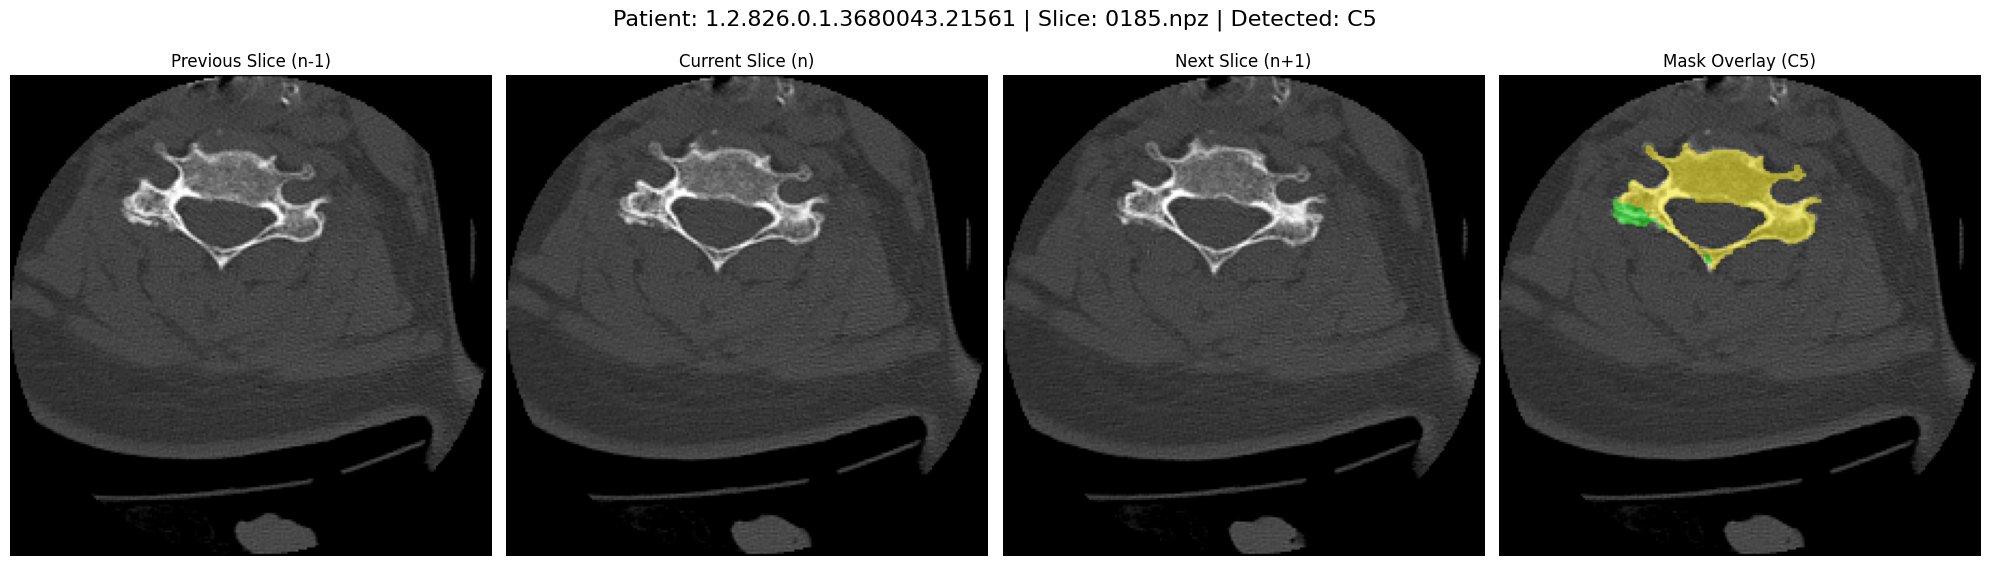

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

# --- [1. 설정] ---
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
DET_DATA_DIR = os.path.join(BASE_DIR, 'detection_preprocessed')

def visualize_det_sample(patient_uid=None, slice_idx=None):
    # 환자 및 슬라이스 무작위 선택 (지정하지 않았을 경우)
    if patient_uid is None:
        patient_folders = [d for d in os.listdir(DET_DATA_DIR) if os.path.isdir(os.path.join(DET_DATA_DIR, d))]
        patient_uid = np.random.choice(patient_folders)
    
    slice_path = os.path.join(DET_DATA_DIR, patient_uid)
    slice_files = glob.glob(os.path.join(slice_path, "*.npz"))
    
    if not slice_files:
        print(f"❌ {patient_uid} 폴더에 데이터가 없습니다.")
        return

    target_file = np.random.choice(slice_files) if slice_idx is None else os.path.join(slice_path, f"{slice_idx:04d}.npz")

    # --- [2. 데이터 로드] ---
    with np.load(target_file) as loaded:
        data = loaded['data'] # (4, 512, 512)
    
    img_prev = data[0] # n-1 슬라이스
    img_curr = data[1] # n 슬라이스 (메인)
    img_next = data[2] # n+1 슬라이스
    mask_norm = data[3] # 0~1로 정규화된 마스크
    
    # 마스크 복원 (0~7)
    mask = np.round(mask_norm * 7).astype(np.uint8)
    v_level = np.max(mask)
    v_name = {0:'None', 1:'C1', 2:'C2', 3:'C3', 4:'C4', 5:'C5', 6:'C6', 7:'C7'}.get(v_level, 'Unknown')

    # --- [3. 시각화] ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    plt.suptitle(f"Patient: {patient_uid} | Slice: {os.path.basename(target_file)} | Detected: {v_name}", fontsize=16)

    # 1채널: 이전 슬라이스
    axes[0].imshow(img_prev, cmap='gray')
    axes[0].set_title("Previous Slice (n-1)")
    axes[0].axis('off')

    # 2채널: 현재 슬라이스 (메인)
    axes[1].imshow(img_curr, cmap='gray')
    axes[1].set_title("Current Slice (n)")
    axes[1].axis('off')

    # 3채널: 다음 슬라이스
    axes[2].imshow(img_next, cmap='gray')
    axes[2].set_title("Next Slice (n+1)")
    axes[2].axis('off')

    # 4채널: 마스크 오버레이 (현재 슬라이스 기준)
    axes[3].imshow(img_curr, cmap='gray')
    if np.any(mask > 0):
        masked = np.ma.masked_where(mask == 0, mask)
        axes[3].imshow(masked, cmap='nipy_spectral', alpha=0.5, vmin=0, vmax=7)
    axes[3].set_title(f"Mask Overlay ({v_name})")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

# 실행: 무작위 샘플 확인
visualize_det_sample()

## manifest

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import glob

# --- [1. 경로 설정] ---
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
DET_DATA_DIR = os.path.join(BASE_DIR, 'detection_preprocessed')
TRAIN_CSV_PATH = os.path.join(BASE_DIR, 'filtered_train.csv')
BBOX_CSV_PATH = os.path.join(BASE_DIR, 'filtered_train_bounding_boxes.csv') # 바운딩 박스 파일

# --- [2. 데이터 로드 및 전처리] ---
df_train = pd.read_csv(TRAIN_CSV_PATH).set_index('StudyInstanceUID')
df_bbox = pd.read_csv(BBOX_CSV_PATH)

# BBox 데이터를 (UID, slice_number)로 빠르게 조회하기 위해 딕셔너리화
# 같은 슬라이스에 여러 박스가 있을 수 있으므로 리스트로 보관
bbox_dict = df_bbox.groupby(['StudyInstanceUID', 'slice_number']).apply(lambda x: x[['x', 'y', 'width', 'height']].values.tolist()).to_dict()

manifest_data = []

# --- [3. 슬라이스 스캔 및 정밀 라벨링] ---
patient_folders = [d for d in os.listdir(DET_DATA_DIR) if os.path.isdir(os.path.join(DET_DATA_DIR, d))]
print(f"🚀 BBox 정보를 포함하여 {len(patient_folders)}명의 데이터를 정밀 스캔합니다.")

for uid in tqdm(patient_folders):
    if uid not in df_train.index:
        continue
    
    slice_files = sorted(glob.glob(os.path.join(DET_DATA_DIR, uid, "*.npz")))

    for f_path in slice_files:
        try:
            # 파일명에서 슬라이스 번호 추출 (예: 0145.npz -> 145)
            # 주의: 이 번호가 BBox CSV의 slice_number와 일치해야 합니다.
            slice_idx = int(os.path.basename(f_path).split('.')[0])
            
            # 1. 기본적인 뼈 레벨 확인 (마스크 채널)
            loaded = np.load(f_path)
            data = loaded['data'] 
            mask_channel = data[3]
            vertebra_level = int(np.round(np.max(mask_channel) * 7))
            
            # 2. 정밀 라벨링 로직
            # 기본값은 0 (골절 없음)
            fracture_label = 0
            box_coords = []

            # 해당 (환자, 슬라이스)에 바운딩 박스 정보가 있는지 확인
            if (uid, slice_idx) in bbox_dict:
                fracture_label = 1
                box_coords = bbox_dict[(uid, slice_idx)] # [[x, y, w, h], ...]

            manifest_data.append({
                'StudyInstanceUID': uid,
                'slice_idx': slice_idx,
                'file_path': os.path.relpath(f_path, BASE_DIR),
                'ver_level': vertebra_level,
                'fracture': fracture_label,
                'bbox': box_coords if box_coords else None # 박스 좌표 저장
            })
            
        except Exception as e:
            print(f"❌ {uid} 처리 중 오류: {e}")

# --- [4. 결과 저장] ---
df_manifest = pd.DataFrame(manifest_data)
save_path = os.path.join(BASE_DIR, 'det_train_manifest.csv')
df_manifest.to_csv(save_path, index=False)

print(f"\n✨ 정밀 Manifest 생성 완료!")
print(f"📊 총 슬라이스 수: {len(df_manifest)}")
print(f"🎯 BBox 기준 골절 슬라이스 수: {df_manifest['fracture'].sum()}")

C:\Users\smc\AppData\Local\Temp\ipykernel_8088\1414522711.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bbox_dict = df_bbox.groupby(['StudyInstanceUID', 'slice_number']).apply(lambda x: x[['x', 'y', 'width', 'height']].values.tolist()).to_dict()


🚀 BBox 정보를 포함하여 235명의 데이터를 정밀 스캔합니다.


100%|██████████| 235/235 [13:14<00:00,  3.38s/it]


✨ 정밀 Manifest 생성 완료!
📊 총 슬라이스 수: 53654
🎯 BBox 기준 골절 슬라이스 수: 7209


## manifest 2트

In [5]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import glob

# --- [1. 경로 설정] ---
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
DET_DATA_DIR = os.path.join(BASE_DIR, 'detection_preprocessed')
TRAIN_CSV_PATH = os.path.join(BASE_DIR, 'filtered_train.csv')
BBOX_CSV_PATH = os.path.join(BASE_DIR, 'filtered_train_bounding_boxes.csv') # 바운딩 박스 파일

# --- [2. 데이터 로드 및 전처리] ---
df_train = pd.read_csv(TRAIN_CSV_PATH).set_index('StudyInstanceUID')
df_bbox = pd.read_csv(BBOX_CSV_PATH)

# BBox 데이터를 (UID, slice_number)로 빠르게 조회하기 위해 딕셔너리화
# 같은 슬라이스에 여러 박스가 있을 수 있으므로 리스트로 보관
bbox_dict = df_bbox.groupby(['StudyInstanceUID', 'slice_number']).apply(lambda x: x[['x', 'y', 'width', 'height']].values.tolist()).to_dict()

manifest_data = []

# --- [3. 슬라이스 스캔 및 정밀 라벨링] ---
patient_folders = [d for d in os.listdir(DET_DATA_DIR) if os.path.isdir(os.path.join(DET_DATA_DIR, d))]
print(f"🚀 BBox 정보를 포함하여 {len(patient_folders)}명의 데이터를 정밀 스캔합니다.")

ORIG_SIZE = 512

for uid in tqdm(patient_folders):
    if uid not in df_train.index:
        continue
    
    slice_files = sorted(glob.glob(os.path.join(DET_DATA_DIR, uid, "*.npz")))

    for f_path in slice_files:
        try:
            slice_idx = int(os.path.basename(f_path).split('.')[0])
            
            # 데이터 로드 및 뼈 번호 확인
            loaded = np.load(f_path)
            mask_channel = loaded['data'][3]
            vertebra_level = int(np.round(np.max(mask_channel) * 7))
            
            fracture_label = 0
            norm_boxes = [] # 정규화된 좌표를 담을 곳

            if (uid, slice_idx) in bbox_dict:
                fracture_label = 1
                for box in bbox_dict[(uid, slice_idx)]:
                    x, y, w, h = box
                    
                    # 🎯 여기서 0~1 사이로 미리 정규화해버립니다!
                    # 나중에 224로 리사이즈했든 512로 했든 상관없어집니다.
                    x_n = x / ORIG_SIZE
                    y_n = y / ORIG_SIZE
                    w_n = w / ORIG_SIZE
                    h_n = h / ORIG_SIZE
                    
                    # 안전장치: 0~1 범위를 절대 벗어나지 않게 고정
                    norm_boxes.append([
                        np.clip(x_n, 0, 1), 
                        np.clip(y_n, 0, 1), 
                        np.clip(w_n, 0, 1), 
                        np.clip(h_n, 0, 1)
                    ])

            manifest_data.append({
                'StudyInstanceUID': uid,
                'slice_idx': slice_idx,
                'file_path': os.path.relpath(f_path, BASE_DIR),
                'ver_level': vertebra_level,
                'fracture': fracture_label,
                'bbox': norm_boxes if norm_boxes else None # 이제 0~1 좌표가 저장됨!
            })
            
        except Exception as e:
            print(f"❌ {uid} 처리 중 오류: {e}")

# --- [4. 결과 저장] ---
df_manifest = pd.DataFrame(manifest_data)
save_path = os.path.join(BASE_DIR, 'det_train_manifest.csv')
df_manifest.to_csv(save_path, index=False)

print(f"\n✨ 정밀 Manifest 생성 완료!")
print(f"📊 총 슬라이스 수: {len(df_manifest)}")
print(f"🎯 BBox 기준 골절 슬라이스 수: {df_manifest['fracture'].sum()}")

C:\Users\smc\AppData\Local\Temp\ipykernel_7376\1703382287.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bbox_dict = df_bbox.groupby(['StudyInstanceUID', 'slice_number']).apply(lambda x: x[['x', 'y', 'width', 'height']].values.tolist()).to_dict()


🚀 BBox 정보를 포함하여 235명의 데이터를 정밀 스캔합니다.


100%|██████████| 235/235 [05:56<00:00,  1.52s/it]


✨ 정밀 Manifest 생성 완료!
📊 총 슬라이스 수: 52224
🎯 BBox 기준 골절 슬라이스 수: 7199


## train/val 분할

In [15]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. 경로 설정 (사용자님의 실제 경로 기준)
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
MANIFEST_PATH = os.path.join(BASE_DIR, 'det_train_manifest.csv') # 최신 매니페스트

# 2. 데이터 로드
df = pd.read_csv(MANIFEST_PATH)

# 3. 고유 환자 ID 추출 (Patient-level Split을 위해)
unique_pids = df['StudyInstanceUID'].unique()

# 4. 환자 리스트 분할 (8:2 비율)
# random_state를 고정하여 실험의 재현성을 확보합니다.
train_pids, val_pids = train_test_split(
    unique_pids, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

# 5. 분할된 ID를 바탕으로 데이터프레임 필터링
train_df = df[df['StudyInstanceUID'].isin(train_pids)].reset_index(drop=True)
val_df = df[df['StudyInstanceUID'].isin(val_pids)].reset_index(drop=True)

# 6. 분할된 CSV 저장 (나중에 Dataset 클래스에서 이 파일을 읽습니다)
train_df.to_csv(os.path.join(BASE_DIR, 'det_train_split.csv'), index=False)
val_df.to_csv(os.path.join(BASE_DIR, 'det_val_split.csv'), index=False)

# 7. 결과 출력 및 검증
print(f"✅ 데이터 분할 완료")
print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"Total Patients: {len(unique_pids)}")
print(f"Train: {len(train_pids):>4} patients | {len(train_df):>6} slices")
print(f"Val:   {len(val_pids):>4} patients | {len(val_df):>6} slices")
print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

# 골절(1)과 정상(0)의 비율 확인 (사용자님 컬럼명 'fracture' 적용)
train_counts = train_df['fracture'].value_counts()
val_counts = val_df['fracture'].value_counts()

print(f"📈 [Train Ratio] Normal: {train_counts[0]:>5} | Fracture: {train_counts[1]:>5} ({train_counts[1]/len(train_df)*100:.1f}%)")
print(f"📉 [Val Ratio]   Normal: {val_counts[0]:>5} | Fracture: {val_counts[1]:>5} ({val_counts[1]/len(val_df)*100:.1f}%)")

✅ 데이터 분할 완료
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Total Patients: 235
Train:  188 patients |  42869 slices
Val:     47 patients |  10785 slices
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 [Train Ratio] Normal: 36954 | Fracture:  5915 (13.8%)
📉 [Val Ratio]   Normal:  9491 | Fracture:  1294 (12.0%)


## train/val 분할 - 5 fold

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
import os

# 1. 경로 설정
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
MANIFEST_PATH = os.path.join(BASE_DIR, 'det_train_manifest.csv')

# 2. 매니페스트 로드
df = pd.read_csv(MANIFEST_PATH)

# 3. 환자 ID(StudyInstanceUID) 고유값 추출
# 환자 단위로 쪼개야 데이터 누수(Data Leakage)를 막을 수 있습니다!
patient_ids = df['StudyInstanceUID'].unique()
print(f"👥 전체 환자 수: {len(patient_ids)}명")

# 4. K-Fold 설정 (5개, 시드 42 고정)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 환자가 몇 번 Fold에 속하는지 딕셔너리에 저장
patient_to_fold = {}
for fold_num, (train_idx, val_idx) in enumerate(kf.split(patient_ids), 1):
    val_pids = patient_ids[val_idx]
    for pid in val_pids:
        patient_to_fold[pid] = fold_num

# 5. 매니페스트에 Fold 정보 매핑
df['fold'] = df['StudyInstanceUID'].map(patient_to_fold)

# 6. 결과 확인 및 저장
print("\n📊 폴드별 슬라이스 분포:")
print(df['fold'].value_counts().sort_index())

SAVE_PATH = os.path.join(BASE_DIR, 'det_train_manifest_folds.csv')
df.to_csv(SAVE_PATH, index=False)
print(f"\n✨ Fold 정보가 포함된 매니페스트 저장 완료: {SAVE_PATH}")

ModuleNotFoundError: No module named 'torchmetrics'

## det 전처리 (512)

In [1]:
import os
import numpy as np
import pydicom
import SimpleITK as sitk
import cv2
from tqdm import tqdm

# --- [1. 경로 및 설정] ---
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
MASK_DIR = os.path.join(BASE_DIR, 'seg_pseudo_masks') 
# 512용 전용 폴더 권장 (기존 224와 구분)
DET_SAVE_ROOT = os.path.join(BASE_DIR, 'detection_preprocessed_512') 
GROUPS = ['1_mask_and_box', '3_only_box']

# 전처리 설정
WL, WW = 500, 2000
BUFFER = 5 
TARGET_SIZE = 512 # [수정] 224 -> 512로 상향

os.makedirs(DET_SAVE_ROOT, exist_ok=True)

def apply_windowing(img, wl, ww):
    img_min, img_max = wl - ww // 2, wl + ww // 2
    img = np.clip(img, img_min, img_max)
    return ((img - img_min) / ww).astype(np.float32)

# --- [3. 메인 루프] ---
for group in GROUPS:
    image_root = os.path.join(BASE_DIR, group, 'train_images')
    if not os.path.exists(image_root): continue
    
    uids = [d for d in os.listdir(image_root) if os.path.isdir(os.path.join(image_root, d))]
    print(f"\n🚀 [{group}] 그룹 512px 고성능 전처리 시작")

    for uid in tqdm(uids):
        patient_save_dir = os.path.join(DET_SAVE_ROOT, uid)
        if not os.path.exists(patient_save_dir): os.makedirs(patient_save_dir)
        
        try:
            # A. DICOM 정보 수집 및 정렬
            dicom_dir = os.path.join(image_root, uid)
            dcm_files = sorted([f for f in os.listdir(dicom_dir) if f.endswith('.dcm')])
            
            dcm_meta = []
            for f in dcm_files:
                ds = pydicom.dcmread(os.path.join(dicom_dir, f), stop_before_pixels=True)
                dcm_meta.append({
                    'path': os.path.join(dicom_dir, f),
                    'z_pos': float(ds.ImagePositionPatient[2]),
                    'slope': float(getattr(ds, 'RescaleSlope', 1.0)),
                    'intercept': float(getattr(ds, 'RescaleIntercept', 0.0))
                })
            # z_pos 기준 내림차순 정렬 (Head to Tail)
            dcm_meta.sort(key=lambda x: x['z_pos'], reverse=True)
            
            # B. 전체 볼륨 로드 및 512 정규화
            full_vol = []
            for m in dcm_meta:
                ds = pydicom.dcmread(m['path'])
                px = ds.pixel_array.astype(np.float32) * m['slope'] + m['intercept']
                
                # 원본이 512가 아닐 경우를 대비해 resize 수행 (보통 512면 무시됨)
                if px.shape != (TARGET_SIZE, TARGET_SIZE):
                    px = cv2.resize(px, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_LINEAR)
                
                full_vol.append(apply_windowing(px, WL, WW))
            full_vol = np.stack(full_vol, axis=0) # (Z, 512, 512)

            # C. 마스크 로드 및 전처리
            mask_path = os.path.join(MASK_DIR, f"{uid}_mask.nii.gz")
            if not os.path.exists(mask_path): continue
            
            mask_itk = sitk.ReadImage(mask_path)
            mask_vol = sitk.GetArrayFromImage(mask_itk).astype(np.uint8)
            mask_vol = np.flip(mask_vol, axis=(0, 1)) # 축 맞춤

            # D. 슬라이싱 및 저장 (4채널 합성)
            # 마스크가 존재하는 범위 찾기
            z_indices = np.where(np.any(mask_vol > 0, axis=(1, 2)))[0]
            if len(z_indices) == 0: continue
            
            start_z = max(0, z_indices.min() - BUFFER)
            end_z = min(len(full_vol) - 1, z_indices.max() + BUFFER)

            for z in range(start_z, end_z + 1):
                # 2.5D 인접 슬라이스 (전, 본인, 후)
                z_prev = max(0, z - 1)
                z_next = min(len(full_vol) - 1, z + 1)
                
                img_3ch = [full_vol[z_prev], full_vol[z], full_vol[z_next]]
                
                # 마스크 슬라이스 리사이즈 및 정규화
                m_slice = mask_vol[z]
                if m_slice.shape != (TARGET_SIZE, TARGET_SIZE):
                    m_slice = cv2.resize(m_slice, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_NEAREST)
                
                m_slice = m_slice.astype(np.float32) / 7.0 # C1~C7 정규화
                
                # 최종 (4, 512, 512) 결합
                combined = np.stack(img_3ch + [m_slice], axis=0) 
                
                # 저장
                save_path = os.path.join(patient_save_dir, f"{z:04d}.npz")
                np.savez_compressed(save_path, data=combined)

        except Exception as e:
            print(f"❌ {uid} 에러: {e}")

print("\n✨ 512px 전처리 완료!")


🚀 [1_mask_and_box] 그룹 512px 고성능 전처리 시작


100%|██████████| 40/40 [12:17<00:00, 18.43s/it]



🚀 [3_only_box] 그룹 512px 고성능 전처리 시작


100%|██████████| 195/195 [1:01:15<00:00, 18.85s/it]


✨ 512px 전처리 완료!


## manifest (512)

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import glob
import ast
from sklearn.model_selection import train_test_split, KFold

# --- [1. 경로 설정] ---
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
# 512px 데이터가 저장된 폴더 (전처리 코드에서 설정한 경로와 일치해야 함)
DET_DATA_DIR = os.path.join(BASE_DIR, 'detection_preprocessed_512')
TRAIN_CSV_PATH = os.path.join(BASE_DIR, 'filtered_train.csv')
BBOX_CSV_PATH = os.path.join(BASE_DIR, 'filtered_train_bounding_boxes.csv') 

# --- [2. 데이터 로드 및 전처리] ---
df_train = pd.read_csv(TRAIN_CSV_PATH).set_index('StudyInstanceUID')
df_bbox = pd.read_csv(BBOX_CSV_PATH)

# BBox 데이터를 (UID, slice_number)로 빠르게 조회하기 위해 딕셔너리화
bbox_dict = df_bbox.groupby(['StudyInstanceUID', 'slice_number']).apply(
    lambda x: x[['x', 'y', 'width', 'height']].values.tolist()
).to_dict()

manifest_data = []

# --- [3. 슬라이스 스캔 및 매니페스트 생성] ---
patient_folders = [d for d in os.listdir(DET_DATA_DIR) if os.path.isdir(os.path.join(DET_DATA_DIR, d))]
print(f"🚀 {len(patient_folders)}명 환자 폴더 스캔 중... (512px 버전)")

ORIG_SIZE = 512  # 원본 해상도 (좌표 정규화 기준)

for uid in tqdm(patient_folders):
    if uid not in df_train.index:
        continue
    
    # 512 전처리된 파일들 검색
    slice_files = sorted(glob.glob(os.path.join(DET_DATA_DIR, uid, "*.npz")))

    for f_path in slice_files:
        try:
            # 파일명에서 슬라이스 번호 추출 (예: 0123.npz -> 123)
            slice_idx = int(os.path.basename(f_path).split('.')[0])
            
            # [최적화] 모든 파일을 열어보지 않고, BBox가 있는 경우에만 상세 정보 확인 가능
            # 하지만 ver_level(뼈 번호)을 정확히 알려면 파일을 열어야 함 (마스크 정보 필요)
            # 여기서는 정확도를 위해 파일을 엽니다. (시간이 좀 걸림)
            
            # 데이터 로드 (뼈 번호 확인용)
            try:
                # np.load 시 allow_pickle=True가 필요할 수도 있음
                with np.load(f_path) as loaded:
                    # 마스크 채널 (마지막 채널)
                    # shape: (4, 512, 512) -> index 3
                    mask_channel = loaded['data'][3]
                    # 마스크 값(0~1 정규화됨)을 다시 정수(0~7)로 복원
                    vertebra_level = int(np.round(np.max(mask_channel) * 7))
            except:
                # 파일 로드 실패 시 건너뜀
                continue
            
            fracture_label = 0
            norm_boxes = [] 

            # 해당 슬라이스에 BBox 정보가 있는지 확인
            if (uid, slice_idx) in bbox_dict:
                fracture_label = 1
                for box in bbox_dict[(uid, slice_idx)]:
                    x, y, w, h = box
                    
                    # 512 기준 정규화 (0~1)
                    x_n, y_n = x / ORIG_SIZE, y / ORIG_SIZE
                    w_n, h_n = w / ORIG_SIZE, h / ORIG_SIZE
                    
                    norm_boxes.append([
                        np.clip(x_n, 0, 1), 
                        np.clip(y_n, 0, 1), 
                        np.clip(w_n, 0, 1), 
                        np.clip(h_n, 0, 1)
                    ])

            manifest_data.append({
                'StudyInstanceUID': uid,
                'slice_idx': slice_idx,
                'file_path': os.path.relpath(f_path, BASE_DIR), # 상대 경로 저장
                'ver_level': vertebra_level,
                'fracture': fracture_label,
                'bbox': norm_boxes if norm_boxes else None 
            })
            
        except Exception as e:
            print(f"❌ {uid} - {slice_idx} 처리 중 오류: {e}")

# 전체 매니페스트 DataFrame 생성
df_manifest = pd.DataFrame(manifest_data)
print(f"\n📊 총 슬라이스 수: {len(df_manifest)}")
print(f"🎯 골절 슬라이스 수: {df_manifest['fracture'].sum()}")

# --- [4. Train / Val / Fold 분할] ---
# 환자 ID 기준 분할 (Data Leakage 방지)
unique_pids = df_manifest['StudyInstanceUID'].unique()

# A. 5-Fold 교차검증용 컬럼 생성 (추천)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
df_manifest['fold'] = -1

for fold_idx, (_, val_idx) in enumerate(kf.split(unique_pids), 1):
    val_pids = unique_pids[val_idx]
    df_manifest.loc[df_manifest['StudyInstanceUID'].isin(val_pids), 'fold'] = fold_idx

# 저장 (Fold 정보 포함된 전체 통합 파일)
save_path_fold = os.path.join(BASE_DIR, 'det_train_manifest_512_folds.csv')
df_manifest.to_csv(save_path_fold, index=False)
print(f"\n✨ [5-Fold] 매니페스트 저장 완료: {save_path_fold}")

C:\Users\smc\AppData\Local\Temp\ipykernel_24560\3264147089.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bbox_dict = df_bbox.groupby(['StudyInstanceUID', 'slice_number']).apply(


🚀 235명 환자 폴더 스캔 중... (512px 버전)


100%|██████████| 235/235 [13:15<00:00,  3.38s/it]


📊 총 슬라이스 수: 52224
🎯 골절 슬라이스 수: 7199

✨ [5-Fold] 매니페스트 저장 완료: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\det_train_manifest_512_folds.csv


## manifest 검증

🚀 데이터 정합성 검증을 시작합니다...

🔍 [검증] UID: 1.2.826.0.1.3680043.25772 | Slice: 231


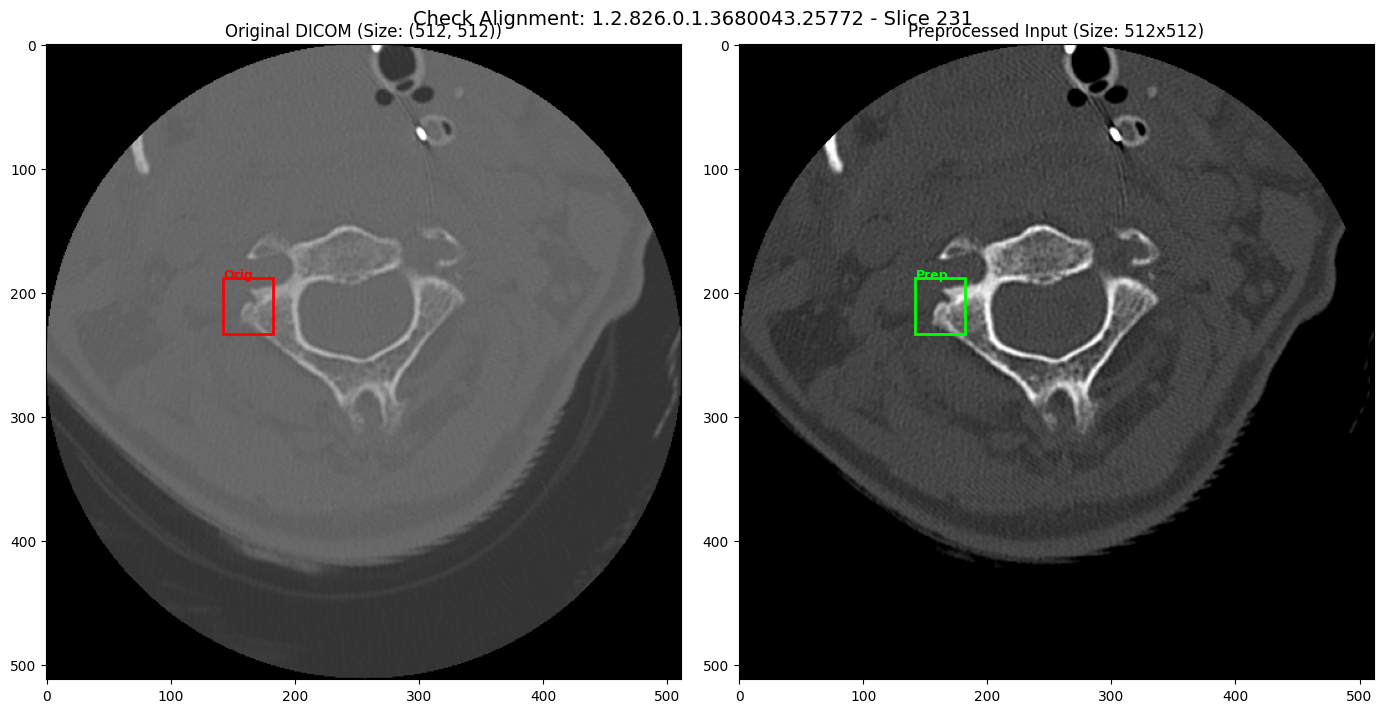


🔍 [검증] UID: 1.2.826.0.1.3680043.26040 | Slice: 127


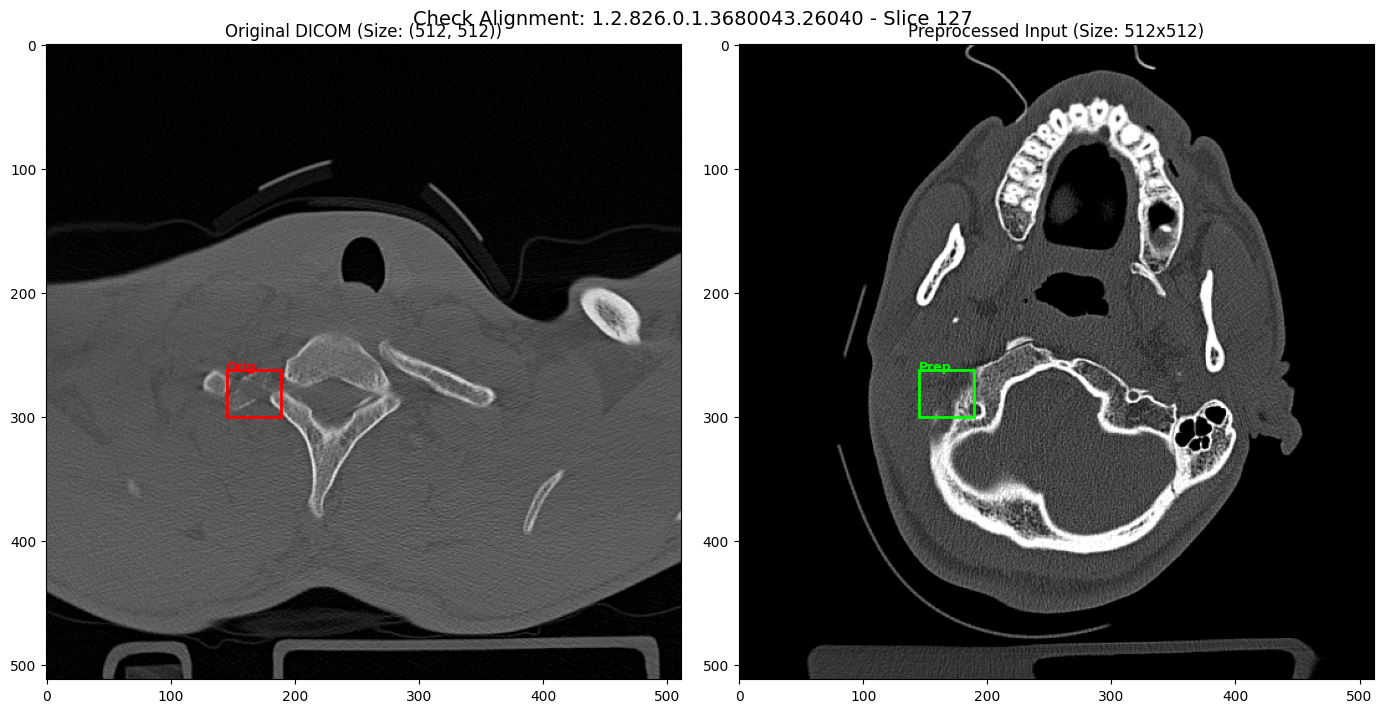


🔍 [검증] UID: 1.2.826.0.1.3680043.20120 | Slice: 226


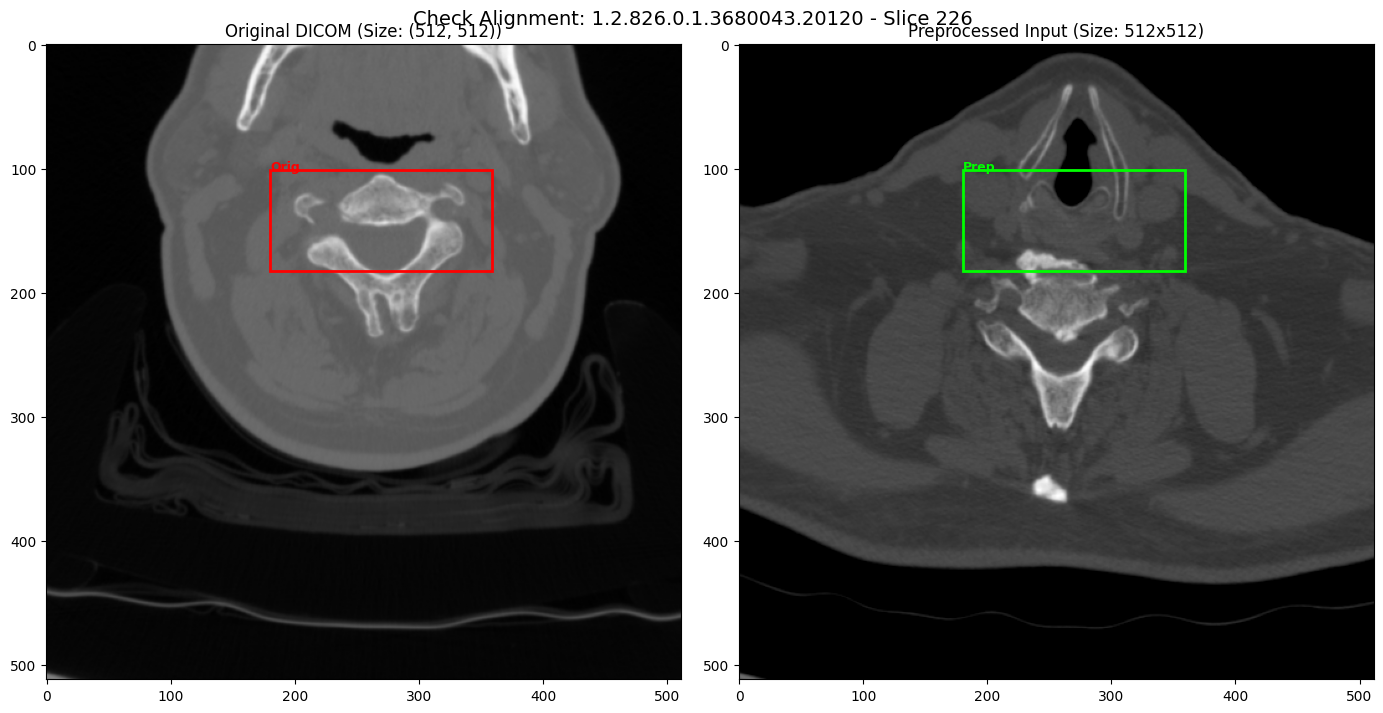

In [3]:
import os
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast
import glob

# ==========================================
# [설정] 본인 환경에 맞게 경로 확인 필수!
# ==========================================
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
MANIFEST_PATH = os.path.join(BASE_DIR, 'det_train_manifest_512_folds.csv')     # 학습용 매니페스트 (전처리 후)
ORIG_BBOX_PATH = os.path.join(BASE_DIR, 'filtered_train_bounding_boxes.csv') # 원본 좌표 CSV

# 원본 DICOM이 들어있는 폴더들 (전처리 코드가 참조했던 경로들)
DICOM_SEARCH_DIRS = [
    os.path.join(BASE_DIR, '1_mask_and_box', 'train_images'),
    os.path.join(BASE_DIR, '3_only_box', 'train_images'),
    os.path.join(BASE_DIR, 'train_images') # 혹시 모를 기본 경로
]

def find_dicom_file(uid, slice_idx):
    """UID와 Slice 번호로 원본 DICOM 파일 경로를 찾습니다."""
    for d_dir in DICOM_SEARCH_DIRS:
        patient_dir = os.path.join(d_dir, uid)
        if os.path.exists(patient_dir):
            # 파일명이 1.dcm, 2.dcm ... 또는 001.dcm 형식이니 확인
            # 간단히 int(slice_idx).dcm으로 시도
            fname = f"{int(slice_idx)}.dcm"
            path = os.path.join(patient_dir, fname)
            if os.path.exists(path):
                return path
            
            # 혹시 파일명이 다를 경우를 대비해 폴더 내 검색 (느림)
            # files = os.listdir(patient_dir) # 필요시 구현
    return None

def compare_visualization():
    print("🚀 데이터 정합성 검증을 시작합니다...")
    
    # 1. 데이터 로드
    if not os.path.exists(MANIFEST_PATH) or not os.path.exists(ORIG_BBOX_PATH):
        print("❌ CSV 파일 경로를 확인해주세요.")
        return

    df_mani = pd.read_csv(MANIFEST_PATH)
    df_orig = pd.read_csv(ORIG_BBOX_PATH)

    # 2. 골절 케이스 랜덤 샘플링
    frac_df = df_mani[df_mani['fracture'] == 1]
    if len(frac_df) == 0:
        print("⚠️ 학습용 매니페스트에 골절 데이터가 없습니다.")
        return

    # 랜덤으로 3개 정도만 뽑아서 비교
    samples = frac_df.sample(n=3)

    for idx, row in samples.iterrows():
        uid = row['StudyInstanceUID']
        slice_idx = row['slice_idx']
        
        print(f"\n🔍 [검증] UID: {uid} | Slice: {slice_idx}")

        # --- [A] 원본 데이터 준비 ---
        dicom_path = find_dicom_file(uid, slice_idx)
        if not dicom_path:
            print(f"   ⚠️ 원본 DICOM을 찾을 수 없어 건너뜁니다.")
            continue
            
        ds = pydicom.dcmread(dicom_path)
        img_orig = ds.pixel_array
        
        # 원본 BBox (Absolute Coordinates)
        orig_boxes = df_orig[
            (df_orig['StudyInstanceUID'] == uid) & 
            (df_orig['slice_number'] == slice_idx)
        ]

        # --- [B] 전처리 데이터 준비 ---
        npz_path = os.path.join(BASE_DIR, row['file_path'])
        if not os.path.exists(npz_path):
            print(f"   ⚠️ 전처리 NPZ 파일을 찾을 수 없습니다: {row['file_path']}")
            continue
            
        with np.load(npz_path) as loaded:
            # 4채널 중 2번째 채널(Index 1)이 현재 슬라이스 이미지
            img_prep = loaded['data'][1] 
        
        # 전처리 BBox (Normalized 0~1)
        prep_boxes = []
        try:
            raw_bbox = row['bbox']
            if isinstance(raw_bbox, str):
                if 'np.float64' in raw_bbox:
                    raw_bbox = raw_bbox.replace('np.float64(', '').replace(')', '')
                prep_boxes = ast.literal_eval(raw_bbox)
            elif isinstance(raw_bbox, list):
                prep_boxes = raw_bbox
        except: pass

        # --- [C] 시각화 그리기 ---
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))
        
        # 1. 왼쪽: 원본 DICOM
        axes[0].imshow(img_orig, cmap='gray')
        axes[0].set_title(f"Original DICOM (Size: {img_orig.shape})")
        for _, b_row in orig_boxes.iterrows():
            # x, y, w, h
            rect = patches.Rectangle(
                (b_row['x'], b_row['y']), b_row['width'], b_row['height'],
                linewidth=2, edgecolor='red', facecolor='none'
            )
            axes[0].add_patch(rect)
            axes[0].text(b_row['x'], b_row['y'], 'Orig', color='red', fontsize=9, weight='bold')

        # 2. 오른쪽: 전처리 NPZ
        axes[1].imshow(img_prep, cmap='gray')
        h_p, w_p = img_prep.shape
        axes[1].set_title(f"Preprocessed Input (Size: {h_p}x{w_p})")
        
        for box in prep_boxes:
            # box: [xn, yn, wn, hn] (0~1 정규화됨)
            xn, yn, wn, hn = box
            
            # 다시 픽셀 좌표로 복원 (Denormalize)
            x = xn * w_p
            y = yn * h_p
            w = wn * w_p
            h = hn * h_p
            
            rect = patches.Rectangle(
                (x, y), w, h,
                linewidth=2, edgecolor='lime', facecolor='none'
            )
            axes[1].add_patch(rect)
            axes[1].text(x, y, 'Prep', color='lime', fontsize=9, weight='bold')

        plt.suptitle(f"Check Alignment: {uid} - Slice {slice_idx}", fontsize=14)
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    compare_visualization()

## manifest 수정

In [4]:
import os
import pandas as pd
import numpy as np
import pydicom
from tqdm import tqdm
import glob

# ==========================================
# [설정] 경로 확인 필수
# ==========================================
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
# 512px 또는 224px 전처리된 폴더 경로 (사용자님 상황에 맞게 선택)
DET_DATA_DIR = os.path.join(BASE_DIR, 'detection_preprocessed_512') 
# 원본 이미지가 있는 폴더 (DICOM 헤더 읽기용)
ORIG_IMG_DIRS = [
    os.path.join(BASE_DIR, '1_mask_and_box', 'train_images'),
    os.path.join(BASE_DIR, '3_only_box', 'train_images'),
    os.path.join(BASE_DIR, 'train_images')
]
BBOX_CSV_PATH = os.path.join(BASE_DIR, 'filtered_train_bounding_boxes.csv') 
TRAIN_CSV_PATH = os.path.join(BASE_DIR, 'filtered_train.csv')

def get_dicom_dir(uid):
    for d in ORIG_IMG_DIRS:
        path = os.path.join(d, uid)
        if os.path.exists(path):
            return path
    return None

def generate_correct_manifest():
    print("🚀 슬라이스 번호 정렬 보정을 시작합니다...")
    
    # 1. BBox 데이터 로드
    df_bbox = pd.read_csv(BBOX_CSV_PATH)
    # 검색 속도를 위해 Dictionary로 변환: (UID, slice_number) -> [boxes]
    bbox_dict = df_bbox.groupby(['StudyInstanceUID', 'slice_number']).apply(
        lambda x: x[['x', 'y', 'width', 'height']].values.tolist()
    ).to_dict()
    
    # 2. Train 리스트 로드
    df_train = pd.read_csv(TRAIN_CSV_PATH).set_index('StudyInstanceUID')
    
    # 3. 전처리된 환자 폴더 스캔
    if not os.path.exists(DET_DATA_DIR):
        print(f"❌ 전처리 폴더가 없습니다: {DET_DATA_DIR}")
        return

    patient_folders = [d for d in os.listdir(DET_DATA_DIR) if os.path.isdir(os.path.join(DET_DATA_DIR, d))]
    manifest_data = []
    
    ORIG_SIZE = 512 # 좌표 정규화 기준 (원본 해상도)

    for uid in tqdm(patient_folders):
        if uid not in df_train.index: continue
        
        dicom_dir = get_dicom_dir(uid)
        if not dicom_dir: continue
        
        # --- [핵심 로직: 매핑 테이블 생성] ---
        dcm_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
        
        # 1. DICOM 헤더에서 (Z위치, 인스턴스 번호, 파일명) 추출
        slices_meta = []
        for f in dcm_files:
            try:
                ds = pydicom.dcmread(os.path.join(dicom_dir, f), stop_before_pixels=True)
                slices_meta.append({
                    'z_pos': float(ds.ImagePositionPatient[2]),
                    'instance_num': int(ds.InstanceNumber), # 이게 CSV의 slice_number와 매칭됨
                    'file_name': f
                })
            except: pass
            
        # 2. 전처리 코드와 "똑같은 로직"으로 정렬 (Z축 내림차순)
        # 이 정렬 순서가 곧 0000.npz, 0001.npz 파일명의 순서입니다.
        slices_meta.sort(key=lambda x: x['z_pos'], reverse=True)
        
        # 3. NPZ 인덱스 매칭
        # npz_idx: 전처리된 파일 번호 (0, 1, 2...)
        # meta['instance_num']: 원본 정답지(CSV)의 슬라이스 번호
        for npz_idx, meta in enumerate(slices_meta):
            real_slice_num = meta['instance_num']
            
            # 해당 순번의 NPZ 파일이 실제로 존재하는지 확인
            npz_filename = f"{npz_idx:04d}.npz"
            npz_path = os.path.join(DET_DATA_DIR, uid, npz_filename)
            
            if not os.path.exists(npz_path):
                continue
            
            # --- [라벨 매칭] ---
            # 이제 "저장된 순서(npz_idx)"가 아니라 "실제 번호(real_slice_num)"로 정답을 찾습니다.
            fracture_label = 0
            norm_boxes = []
            
            # CSV에서 (UID, 실제번호)로 검색
            if (uid, real_slice_num) in bbox_dict:
                fracture_label = 1
                for box in bbox_dict[(uid, real_slice_num)]:
                    x, y, w, h = box
                    # 정규화
                    norm_boxes.append([
                        np.clip(x / ORIG_SIZE, 0, 1),
                        np.clip(y / ORIG_SIZE, 0, 1),
                        np.clip(w / ORIG_SIZE, 0, 1),
                        np.clip(h / ORIG_SIZE, 0, 1)
                    ])

            # 뼈 번호(ver_level) 추출을 위해 NPZ 잠시 로드 (필요시 생략 가능하지만 권장)
            # 여기서는 속도를 위해 생략하고, 나중에 Dataset에서 로드하거나
            # 정확성을 위해 지금 읽습니다. (권장: 읽기)
            ver_level = 0
            try:
                 with np.load(npz_path) as loaded:
                    mask = loaded['data'][3]
                    ver_level = int(np.round(np.max(mask) * 7))
            except: pass

            manifest_data.append({
                'StudyInstanceUID': uid,
                'slice_idx': npz_idx, # 파일명 번호 (0000.npz)
                'original_slice_num': real_slice_num, # 참고용 (실제 DICOM 번호)
                'file_path': os.path.relpath(npz_path, BASE_DIR),
                'ver_level': ver_level,
                'fracture': fracture_label,
                'bbox': norm_boxes if norm_boxes else None
            })

    # 저장
    df_manifest = pd.DataFrame(manifest_data)
    
    # 5-Fold 분할 (기존 로직 유지)
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    df_manifest['fold'] = -1
    uids = df_manifest['StudyInstanceUID'].unique()
    for f_idx, (_, val_idx) in enumerate(kf.split(uids), 1):
        df_manifest.loc[df_manifest['StudyInstanceUID'].isin(uids[val_idx]), 'fold'] = f_idx
        
    save_path = os.path.join(BASE_DIR, 'det_train_manifest_aligned_folds.csv')
    df_manifest.to_csv(save_path, index=False)
    
    print(f"\n✨ 보정된 매니페스트 저장 완료: {save_path}")
    print(f"📊 총 슬라이스: {len(df_manifest)}")
    print(f"🎯 골절 슬라이스: {df_manifest['fracture'].sum()}")

if __name__ == '__main__':
    generate_correct_manifest()

🚀 슬라이스 번호 정렬 보정을 시작합니다...


C:\Users\smc\AppData\Local\Temp\ipykernel_24560\2442753732.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bbox_dict = df_bbox.groupby(['StudyInstanceUID', 'slice_number']).apply(
100%|██████████| 235/235 [18:13<00:00,  4.65s/it]


✨ 보정된 매니페스트 저장 완료: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\det_train_manifest_aligned_folds.csv
📊 총 슬라이스: 52224
🎯 골절 슬라이스: 7205


🚀 총 7205개의 골절 슬라이스를 이미지로 저장합니다...


  5%|▍         | 355/7205 [00:55<17:44,  6.44it/s]


KeyboardInterrupt: 

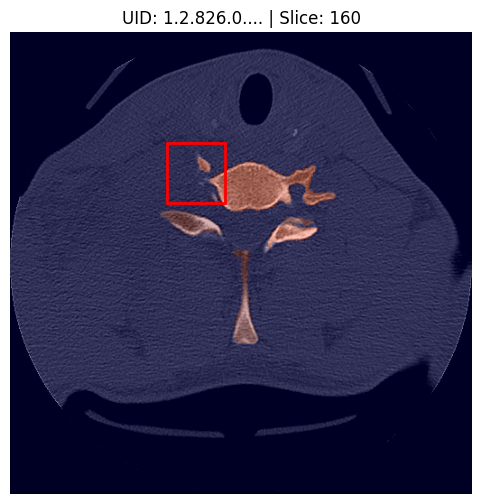

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast
import re # 정규표현식 사용
from tqdm import tqdm

# [설정]
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
MANIFEST_PATH = os.path.join(BASE_DIR, 'det_train_manifest_aligned_folds.csv') 
SAVE_DIR = os.path.join(BASE_DIR, 'inspection_results') 
IMG_SIZE = 512

# [핵심 수정] 강력한 파싱 함수 추가
def clean_and_parse_box(bbox_str):
    if not isinstance(bbox_str, str):
        return bbox_str
    
    # 1. 단순 교체 (np.float64( -> 빈 문자열)
    # 괄호 ')' 제거가 위험할 수 있으니 정규식으로 숫자만 남기는게 안전하지만,
    # RSNA 데이터셋 포맷상 단순 교체도 대부분 동작합니다.
    clean_str = bbox_str.replace('np.float64(', '').replace('np.int64(', '').replace(')', '')
    
    try:
        return ast.literal_eval(clean_str)
    except:
        return []

def save_inspection_images():
    if not os.path.exists(MANIFEST_PATH):
        print("❌ 매니페스트 파일이 없습니다.")
        return

    os.makedirs(SAVE_DIR, exist_ok=True)
    df = pd.read_csv(MANIFEST_PATH)
    
    frac_df = df[df['fracture'] == 1].reset_index(drop=True)
    print(f"🚀 총 {len(frac_df)}개의 골절 슬라이스를 이미지로 저장합니다...")
    
    # 테스트용으로 100개만 먼저
    # frac_df = frac_df.iloc[:100] 

    success_cnt = 0
    for idx, row in tqdm(frac_df.iterrows(), total=len(frac_df)):
        try:
            full_path = os.path.join(BASE_DIR, row['file_path'])
            
            with np.load(full_path) as loaded:
                img = loaded['data'][1]
                mask = loaded['data'][3]

            # [수정된 파싱 함수 사용]
            boxes = clean_and_parse_box(row['bbox'])
            
            if not boxes: # 파싱 실패하거나 빈 리스트면 스킵
                continue

            # 시각화
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.imshow(img, cmap='gray')
            ax.imshow(mask, cmap='jet', alpha=0.3, vmin=0, vmax=1)
            
            for box in boxes:
                # 좌표가 4개가 아니면 스킵
                if len(box) != 4: continue
                
                x, y, w, h = box
                # 0~1 정규화된 좌표라면 512 곱하기
                # 혹시 이미 픽셀 좌표라면 그대로 쓰기 (값 범위 체크)
                if x < 1.0 and y < 1.0 and w < 1.0 and h < 1.0:
                    x, y, w, h = x*IMG_SIZE, y*IMG_SIZE, w*IMG_SIZE, h*IMG_SIZE
                
                rect = patches.Rectangle(
                    (x, y), w, h,
                    linewidth=2, edgecolor='red', facecolor='none'
                )
                ax.add_patch(rect)
            
            ax.axis('off')
            ax.set_title(f"UID: {row['StudyInstanceUID'][:10]}... | Slice: {row['slice_idx']}")
            
            save_name = f"{idx:04d}_{row['StudyInstanceUID']}_{row['slice_idx']}.png"
            plt.savefig(os.path.join(SAVE_DIR, save_name))
            plt.close(fig)
            success_cnt += 1

        except Exception as e:
            # print(f"Skipped {idx}: {e}") # 너무 많이 뜨면 주석 처리
            pass

    print(f"\n✅ 검사 완료! 총 {success_cnt}장의 이미지가 저장되었습니다.")
    print(f"📂 저장 폴더: {SAVE_DIR}")

if __name__ == '__main__':
    save_inspection_images()